In [1]:
# Import PyTorch
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms, datasets, models

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

Skipping, found downloaded files in ".\chest-xray-pneumonia" (use force=True to force download)


In [ ]:
if torch.cuda.is_available():
    print("GPU available: ", torch.cuda.get_device_name(0))  # Print the name of the GPU device
else:
    print("GPU not available, using CPU instead.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU not available, using CPU instead.


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(size=(32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.2),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.75, scale=(0.01, 0.01), inplace=False)
])

test_transform = transforms.Compose([
    transforms.Resize(size=(32, 32)),
    transforms.ToTensor()
])

In [ ]:
train_path = 'C:/Users/trank/Downloads/181/chest-xray-pneumonia/chest_xray/train'
test_path = 'C:/Users/trank/Downloads/181/chest-xray-pneumonia/chest_xray/test'
valid_path = 'C:/Users/trank/Downloads/181/chest-xray-pneumonia/chest_xray/val'

In [ ]:
train_data = datasets.ImageFolder(root=train_path,
                                  transform=train_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_path,
                                 transform=test_transform,
                                 target_transform=None)
val_data = datasets.ImageFolder(root=valid_path,
                                transform=test_transform,
                                target_transform=None)

In [ ]:
batch_size = 64
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)


print('Number of training batches', len(train_loader))
print('Number of test batches', len(test_loader))

Number of training batches 82
Number of test batches 10


## Training data with batch_size of 10

Epoch: 1/10, Loss: 0.0000, Train Accuracy: 79.60%, Validation Accuracy: 62.50%
Epoch: 2/10, Loss: 0.0000, Train Accuracy: 90.24%, Validation Accuracy: 81.25%
Epoch: 3/10, Loss: 0.0000, Train Accuracy: 92.06%, Validation Accuracy: 75.00%
Epoch: 4/10, Loss: 0.0000, Train Accuracy: 93.44%, Validation Accuracy: 75.00%
Epoch: 5/10, Loss: 0.0000, Train Accuracy: 93.88%, Validation Accuracy: 75.00%
Epoch: 6/10, Loss: 0.0000, Train Accuracy: 94.06%, Validation Accuracy: 68.75%
Epoch: 7/10, Loss: 0.0000, Train Accuracy: 94.25%, Validation Accuracy: 93.75%
Epoch: 8/10, Loss: 0.0000, Train Accuracy: 94.50%, Validation Accuracy: 81.25%
Epoch: 9/10, Loss: 0.0000, Train Accuracy: 94.52%, Validation Accuracy: 62.50%
Epoch: 10/10, Loss: 0.0000, Train Accuracy: 95.38%, Validation Accuracy: 87.50%


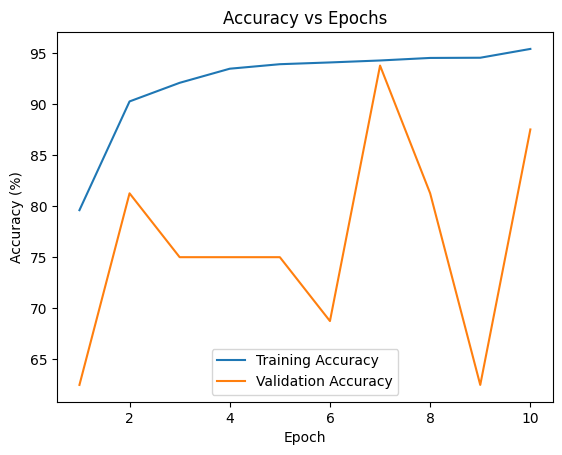

In [ ]:
batch_size = 10
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

running_loss = 0.0
num_epochs = 10
learning_rate = 0.001
print_freq = 100

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # Assuming input images are resized to 32x32
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)  # Adjusted input size
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Initialize the model
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # Move data to GPU
        optimizer.zero_grad()
        output = model(data)
        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    # Print training and validation accuracy for each epoch
    print('Epoch: %d/%d, Loss: %.4f, Train Accuracy: %.2f%%, Validation Accuracy: %.2f%%' % (
        epoch + 1, num_epochs, running_loss / len(train_loader), train_accuracy, val_accuracy))

# Plot accuracy versus epochs
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

## Testing our CNN with batch_size of 10

In [ ]:
batch_size = 10
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# Set the model to evaluation mode
model.eval()

# Initialize variables for calculating accuracy
correct = 0
total = 0

# Iterate through the test dataset
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)  # Move data to GPU
        # Forward pass
        outputs = model(data)
        # Get predicted labels
        _, predicted = torch.max(outputs.data, 1)
        # Update total number of samples
        total += target.size(0)
        # Update number of correctly classified samples
        correct += (predicted == target).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print('Accuracy on test set: {:.2f}%'.format(accuracy))


Accuracy on test set: 81.73%


## Training our CNN with batch_size of 64

Epoch: 1/10, Loss: 0.0000, Train Accuracy: 74.21%, Validation Accuracy: 50.00%
Epoch: 2/10, Loss: 0.0000, Train Accuracy: 84.87%, Validation Accuracy: 62.50%
Epoch: 3/10, Loss: 0.0000, Train Accuracy: 90.72%, Validation Accuracy: 68.75%
Epoch: 4/10, Loss: 0.0000, Train Accuracy: 91.62%, Validation Accuracy: 62.50%
Epoch: 5/10, Loss: 0.0000, Train Accuracy: 92.27%, Validation Accuracy: 68.75%
Epoch: 6/10, Loss: 0.0000, Train Accuracy: 94.00%, Validation Accuracy: 75.00%
Epoch: 7/10, Loss: 0.0000, Train Accuracy: 94.29%, Validation Accuracy: 62.50%
Epoch: 8/10, Loss: 0.0000, Train Accuracy: 93.94%, Validation Accuracy: 62.50%
Epoch: 9/10, Loss: 0.0000, Train Accuracy: 95.15%, Validation Accuracy: 56.25%
Epoch: 10/10, Loss: 0.0000, Train Accuracy: 94.71%, Validation Accuracy: 56.25%


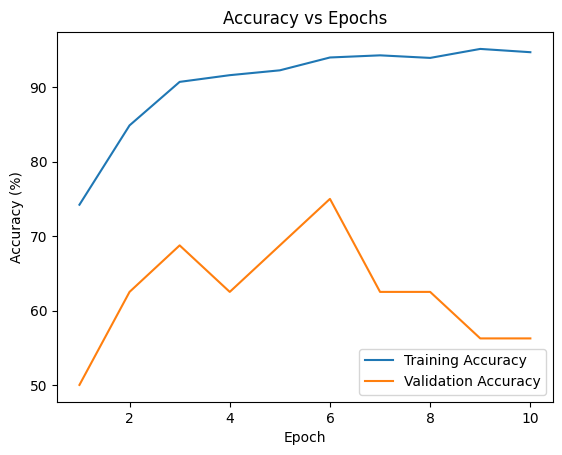

In [ ]:
batch_size = 64
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

running_loss = 0.0
num_epochs = 10
learning_rate = 0.001
print_freq = 100

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # Assuming input images are resized to 32x32
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)  # Adjusted input size
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Initialize the model
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # Move data to GPU
        optimizer.zero_grad()
        output = model(data)
        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    # Print training and validation accuracy for each epoch
    print('Epoch: %d/%d, Loss: %.4f, Train Accuracy: %.2f%%, Validation Accuracy: %.2f%%' % (
        epoch + 1, num_epochs, running_loss / len(train_loader), train_accuracy, val_accuracy))

# Plot accuracy versus epochs
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

## Testing our CNN with batch_size of 64

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize variables for calculating accuracy
correct = 0
total = 0

# Iterate through the test dataset
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)  # Move data to GPU
        # Forward pass
        outputs = model(data)
        # Get predicted labels
        _, predicted = torch.max(outputs.data, 1)
        # Update total number of samples
        total += target.size(0)
        # Update number of correctly classified samples
        correct += (predicted == target).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print('Accuracy on test set: {:.2f}%'.format(accuracy))


Accuracy on test set: 76.92%


## Training with batch_size 128

Epoch: 1/10, Loss: 0.0000, Train Accuracy: 73.77%, Validation Accuracy: 50.00%
Epoch: 2/10, Loss: 0.0000, Train Accuracy: 75.21%, Validation Accuracy: 56.25%
Epoch: 3/10, Loss: 0.0000, Train Accuracy: 85.79%, Validation Accuracy: 62.50%
Epoch: 4/10, Loss: 0.0000, Train Accuracy: 90.64%, Validation Accuracy: 68.75%
Epoch: 5/10, Loss: 0.0000, Train Accuracy: 92.10%, Validation Accuracy: 62.50%
Epoch: 6/10, Loss: 0.0000, Train Accuracy: 93.14%, Validation Accuracy: 75.00%
Epoch: 7/10, Loss: 0.0000, Train Accuracy: 93.96%, Validation Accuracy: 62.50%
Epoch: 8/10, Loss: 0.0000, Train Accuracy: 93.62%, Validation Accuracy: 81.25%
Epoch: 9/10, Loss: 0.0000, Train Accuracy: 94.86%, Validation Accuracy: 75.00%
Epoch: 10/10, Loss: 0.0000, Train Accuracy: 94.92%, Validation Accuracy: 68.75%


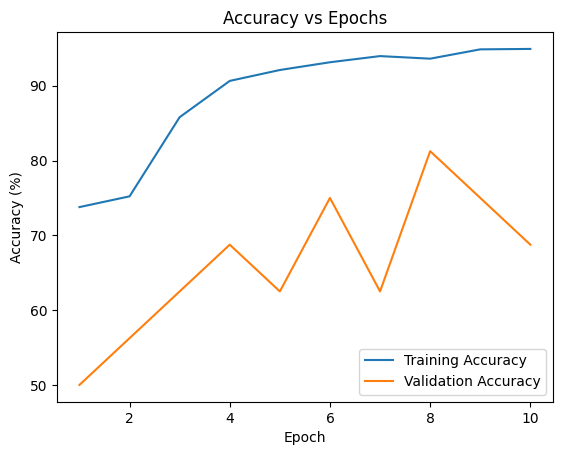

In [ ]:
batch_size = 128
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

num_epochs = 10
learning_rate = 0.001
running_loss = 0.0
print_freq = 100

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # Assuming input images are resized to 32x32
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)  # Adjusted input size
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Initialize the model
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # Move data to GPU
        optimizer.zero_grad()
        output = model(data)
        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    # Print training and validation accuracy for each epoch
    print('Epoch: %d/%d, Loss: %.4f, Train Accuracy: %.2f%%, Validation Accuracy: %.2f%%' % (
        epoch + 1, num_epochs, running_loss / len(train_loader), train_accuracy, val_accuracy))

# Plot accuracy versus epochs
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

## Testing with our CNN (batch_size 128)

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize variables for calculating accuracy
correct = 0
total = 0

# Iterate through the test dataset
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)  # Move data to GPU
        # Forward pass
        outputs = model(data)
        # Get predicted labels
        _, predicted = torch.max(outputs.data, 1)
        # Update total number of samples
        total += target.size(0)
        # Update number of correctly classified samples
        correct += (predicted == target).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print('Accuracy on test set: {:.2f}%'.format(accuracy))

Accuracy on test set: 82.05%


## Training with ResNet50 with batch_size of 10

C:\Users\trank\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\trank\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1/10, Loss: 0.5564, Train Accuracy: 75.33%, Validation Accuracy: 68.75%
Epoch: 2/10, Loss: 0.5221, Train Accuracy: 77.34%, Validation Accuracy: 62.50%
Epoch: 3/10, Loss: 0.5345, Train Accuracy: 77.20%, Validation Accuracy: 56.25%
Epoch: 4/10, Loss: 0.5205, Train Accuracy: 77.70%, Validation Accuracy: 56.25%
Epoch: 5/10, Loss: 0.5269, Train Accuracy: 78.01%, Validation Accuracy: 56.25%
Epoch: 6/10, Loss: 0.5165, Train Accuracy: 78.66%, Validation Accuracy: 62.50%
Epoch: 7/10, Loss: 0.5034, Train Accuracy: 78.51%, Validation Accuracy: 50.00%
Epoch: 8/10, Loss: 0.5082, Train Accuracy: 78.83%, Validation Accuracy: 68.75%
Epoch: 9/10, Loss: 0.4969, Train Accuracy: 78.83%, Validation Accuracy: 56.25%
Epoch: 10/10, Loss: 0.5119, Train Accuracy: 78.72%, Validation Accuracy: 75.00%


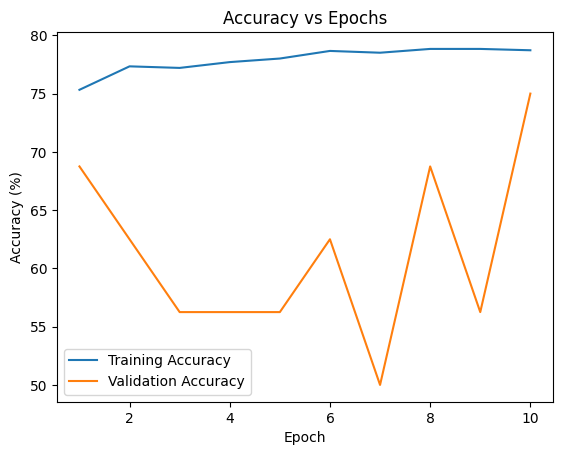

In [ ]:
batch_size = 10
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# Load pre-trained ResNet-50 model
model = torchvision.models.resnet50(pretrained=True)

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Output 2 classes (pneumonia or not pneumonia)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_accuracies = []  # Initialize list to store training accuracies
valid_accuracies = []  # Initialize list to store validation accuracies

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Evaluation on validation set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    valid_accuracy = 100 * correct / total
    valid_accuracies.append(valid_accuracy)

    print('Epoch: %d/%d, Loss: %.4f, Train Accuracy: %.2f%%, Validation Accuracy: %.2f%%' % (
        epoch + 1, num_epochs, running_loss / len(train_loader), train_accuracy, valid_accuracy))

# Plot accuracy versus epoch
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()


## Testing with ResNet50 of batch_size 10

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize variables for calculating accuracy
correct = 0
total = 0

# Iterate through the test dataset
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)  # Move data to GPU
        # Forward pass
        outputs = model(data)
        # Get predicted labels
        _, predicted = torch.max(outputs.data, 1)
        # Update total number of samples
        total += target.size(0)
        # Update number of correctly classified samples
        correct += (predicted == target).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print('Accuracy on test set: {:.2f}%'.format(accuracy))

Accuracy on test set: 66.35%


## Training ResNet50 with a batch_size of 64

Epoch: 1/10, Loss: 0.5165, Train Accuracy: 76.17%, Validation Accuracy: 62.50%
Epoch: 2/10, Loss: 0.4521, Train Accuracy: 79.18%, Validation Accuracy: 62.50%
Epoch: 3/10, Loss: 0.4136, Train Accuracy: 81.46%, Validation Accuracy: 56.25%
Epoch: 4/10, Loss: 0.4245, Train Accuracy: 80.43%, Validation Accuracy: 56.25%
Epoch: 5/10, Loss: 0.4173, Train Accuracy: 81.27%, Validation Accuracy: 62.50%
Epoch: 6/10, Loss: 0.4046, Train Accuracy: 81.90%, Validation Accuracy: 62.50%
Epoch: 7/10, Loss: 0.3955, Train Accuracy: 81.92%, Validation Accuracy: 50.00%
Epoch: 8/10, Loss: 0.4017, Train Accuracy: 81.52%, Validation Accuracy: 62.50%
Epoch: 9/10, Loss: 0.4034, Train Accuracy: 81.58%, Validation Accuracy: 62.50%
Epoch: 10/10, Loss: 0.3946, Train Accuracy: 82.84%, Validation Accuracy: 56.25%


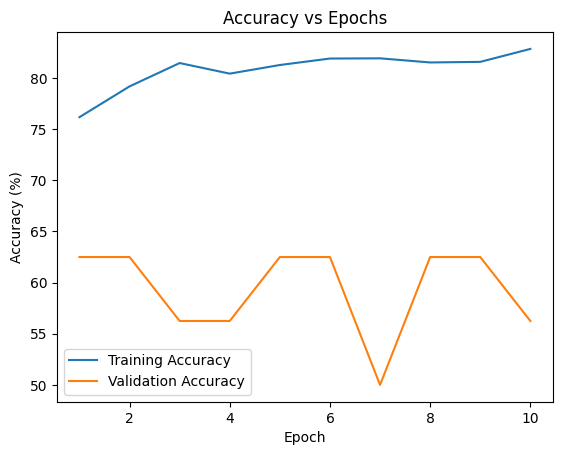

In [ ]:
batch_size = 64
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# Load pre-trained ResNet-50 model
model = torchvision.models.resnet50(pretrained=True)

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Output 2 classes (pneumonia or not pneumonia)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_accuracies = []  # Initialize list to store training accuracies
valid_accuracies = []  # Initialize list to store validation accuracies

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Evaluation on validation set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    valid_accuracy = 100 * correct / total
    valid_accuracies.append(valid_accuracy)

    print('Epoch: %d/%d, Loss: %.4f, Train Accuracy: %.2f%%, Validation Accuracy: %.2f%%' % (
        epoch + 1, num_epochs, running_loss / len(train_loader), train_accuracy, valid_accuracy))

# Plot accuracy versus epoch
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

## Testing ResNet50 with batch_size 64

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize variables for calculating accuracy
correct = 0
total = 0

# Iterate through the test dataset
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)  # Move data to GPU
        # Forward pass
        outputs = model(data)
        # Get predicted labels
        _, predicted = torch.max(outputs.data, 1)
        # Update total number of samples
        total += target.size(0)
        # Update number of correctly classified samples
        correct += (predicted == target).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print('Accuracy on test set: {:.2f}%'.format(accuracy))

Accuracy on test set: 68.11%


## Training with VGG and batch_size of 64

C:\Users\trank\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\trank/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:11<00:00, 47.8MB/s] 


Epoch: 1/10, Loss: 0.9091, Train Accuracy: 76.32%, Validation Accuracy: 81.25%
Epoch: 2/10, Loss: 0.2537, Train Accuracy: 89.44%, Validation Accuracy: 81.25%
Epoch: 3/10, Loss: 0.1963, Train Accuracy: 92.43%, Validation Accuracy: 75.00%
Epoch: 4/10, Loss: 0.1724, Train Accuracy: 93.23%, Validation Accuracy: 75.00%
Epoch: 5/10, Loss: 0.1429, Train Accuracy: 94.67%, Validation Accuracy: 87.50%
Epoch: 6/10, Loss: 0.1233, Train Accuracy: 95.09%, Validation Accuracy: 93.75%
Epoch: 7/10, Loss: 0.1066, Train Accuracy: 96.07%, Validation Accuracy: 93.75%
Epoch: 8/10, Loss: 0.1024, Train Accuracy: 95.95%, Validation Accuracy: 81.25%
Epoch: 9/10, Loss: 0.1068, Train Accuracy: 96.05%, Validation Accuracy: 87.50%
Epoch: 10/10, Loss: 0.1003, Train Accuracy: 96.20%, Validation Accuracy: 87.50%


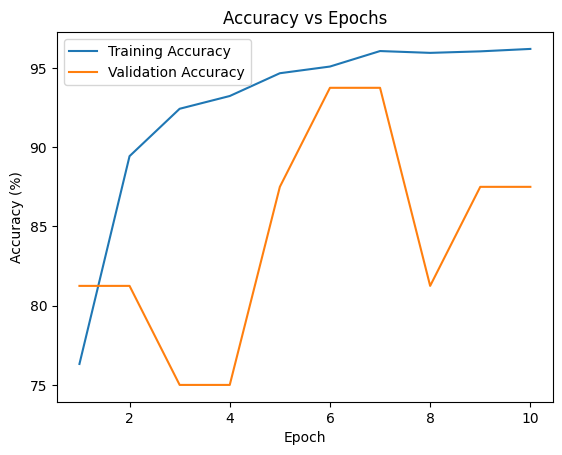

In [ ]:
model = models.vgg16(pretrained=True)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 10  # Set the number of epochs
train_accuracies = []  # Initialize list to store training accuracies
valid_accuracies = []  # Initialize list to store validation accuracies
batch_size = 64

train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Evaluation on validation set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    valid_accuracy = 100 * correct / total
    valid_accuracies.append(valid_accuracy)

    print('Epoch: %d/%d, Loss: %.4f, Train Accuracy: %.2f%%, Validation Accuracy: %.2f%%' % (
        epoch + 1, num_epochs, running_loss / len(train_loader), train_accuracy, valid_accuracy))

# Plot accuracy versus epoch
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

## Testing with VGG with batch_size of 64

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize variables for calculating accuracy
correct = 0
total = 0

# Iterate through the test dataset
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)  # Move data to GPU
        # Forward pass
        outputs = model(data)
        # Get predicted labels
        _, predicted = torch.max(outputs.data, 1)
        # Update total number of samples
        total += target.size(0)
        # Update number of correctly classified samples
        correct += (predicted == target).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print('Accuracy on test set: {:.2f}%'.format(accuracy))

Accuracy on test set: 81.09%


## VGG with batch_size of 10

Epoch: 1/10, Loss: 0.4382, Train Accuracy: 83.68%, Validation Accuracy: 87.50%
Epoch: 2/10, Loss: 0.1537, Train Accuracy: 94.50%, Validation Accuracy: 81.25%
Epoch: 3/10, Loss: 0.1444, Train Accuracy: 94.75%, Validation Accuracy: 87.50%
Epoch: 4/10, Loss: 0.1080, Train Accuracy: 96.17%, Validation Accuracy: 68.75%
Epoch: 5/10, Loss: 0.1146, Train Accuracy: 95.86%, Validation Accuracy: 75.00%
Epoch: 6/10, Loss: 0.0929, Train Accuracy: 96.84%, Validation Accuracy: 81.25%
Epoch: 7/10, Loss: 0.0947, Train Accuracy: 96.57%, Validation Accuracy: 93.75%
Epoch: 8/10, Loss: 0.0872, Train Accuracy: 96.49%, Validation Accuracy: 87.50%
Epoch: 9/10, Loss: 0.0889, Train Accuracy: 96.99%, Validation Accuracy: 87.50%
Epoch: 10/10, Loss: 0.0762, Train Accuracy: 97.14%, Validation Accuracy: 87.50%


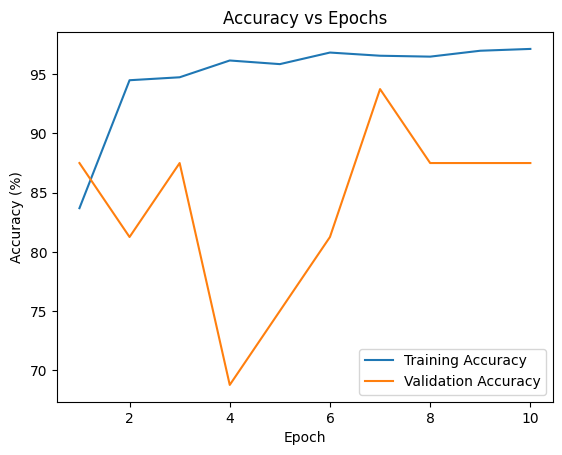

In [ ]:
model = models.vgg16(pretrained=True)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 10  # Set the number of epochs
train_accuracies = []  # Initialize list to store training accuracies
valid_accuracies = []  # Initialize list to store validation accuracies
batch_size = 10

train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Evaluation on validation set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    valid_accuracy = 100 * correct / total
    valid_accuracies.append(valid_accuracy)

    print('Epoch: %d/%d, Loss: %.4f, Train Accuracy: %.2f%%, Validation Accuracy: %.2f%%' % (
        epoch + 1, num_epochs, running_loss / len(train_loader), train_accuracy, valid_accuracy))

# Plot accuracy versus epoch
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

## Testing VGG with batch_size of 10

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize variables for calculating accuracy
correct = 0
total = 0

# Iterate through the test dataset
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)  # Move data to GPU
        # Forward pass
        outputs = model(data)
        # Get predicted labels
        _, predicted = torch.max(outputs.data, 1)
        # Update total number of samples
        total += target.size(0)
        # Update number of correctly classified samples
        correct += (predicted == target).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print('Accuracy on test set: {:.2f}%'.format(accuracy))

Accuracy on test set: 82.37%


## VGG batch_size 64, epoch 50

Epoch: 1/50, Loss: 0.9229, Train Accuracy: 75.02%, Validation Accuracy: 68.75%
Epoch: 2/50, Loss: 0.2475, Train Accuracy: 90.11%, Validation Accuracy: 93.75%
Epoch: 3/50, Loss: 0.1616, Train Accuracy: 93.42%, Validation Accuracy: 50.00%
Epoch: 4/50, Loss: 0.1811, Train Accuracy: 92.85%, Validation Accuracy: 87.50%
Epoch: 5/50, Loss: 0.1207, Train Accuracy: 95.34%, Validation Accuracy: 81.25%
Epoch: 6/50, Loss: 0.1146, Train Accuracy: 95.59%, Validation Accuracy: 93.75%
Epoch: 7/50, Loss: 0.1239, Train Accuracy: 95.05%, Validation Accuracy: 93.75%
Epoch: 8/50, Loss: 0.1004, Train Accuracy: 96.45%, Validation Accuracy: 100.00%
Epoch: 9/50, Loss: 0.1014, Train Accuracy: 96.30%, Validation Accuracy: 93.75%
Epoch: 10/50, Loss: 0.0926, Train Accuracy: 96.53%, Validation Accuracy: 75.00%
Epoch: 11/50, Loss: 0.0987, Train Accuracy: 96.45%, Validation Accuracy: 93.75%
Epoch: 12/50, Loss: 0.0970, Train Accuracy: 96.32%, Validation Accuracy: 87.50%
Epoch: 13/50, Loss: 0.0957, Train Accuracy: 96.6

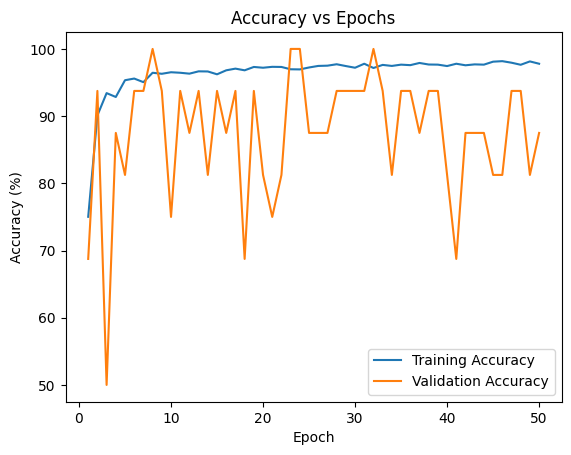

In [ ]:
model = models.vgg16(pretrained=True)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 50  # Set the number of epochs
train_accuracies = []  # Initialize list to store training accuracies
valid_accuracies = []  # Initialize list to store validation accuracies
batch_size = 64

train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Evaluation on validation set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    valid_accuracy = 100 * correct / total
    valid_accuracies.append(valid_accuracy)

    print('Epoch: %d/%d, Loss: %.4f, Train Accuracy: %.2f%%, Validation Accuracy: %.2f%%' % (
        epoch + 1, num_epochs, running_loss / len(train_loader), train_accuracy, valid_accuracy))

# Plot accuracy versus epoch
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

## Testing VGG with epoch 50

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize variables for calculating accuracy
correct = 0
total = 0

# Iterate through the test dataset
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)  # Move data to GPU
        # Forward pass
        outputs = model(data)
        # Get predicted labels
        _, predicted = torch.max(outputs.data, 1)
        # Update total number of samples
        total += target.size(0)
        # Update number of correctly classified samples
        correct += (predicted == target).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print('Accuracy on test set: {:.2f}%'.format(accuracy))

Accuracy on test set: 79.49%


## VGG batch_size 64, epoch 100

Epoch: 1/100, Loss: 0.9411, Train Accuracy: 75.21%, Validation Accuracy: 68.75%
Epoch: 2/100, Loss: 0.2339, Train Accuracy: 89.95%, Validation Accuracy: 93.75%
Epoch: 3/100, Loss: 0.1582, Train Accuracy: 93.94%, Validation Accuracy: 93.75%
Epoch: 4/100, Loss: 0.1582, Train Accuracy: 94.11%, Validation Accuracy: 93.75%
Epoch: 5/100, Loss: 0.1463, Train Accuracy: 94.36%, Validation Accuracy: 93.75%
Epoch: 6/100, Loss: 0.1217, Train Accuracy: 95.21%, Validation Accuracy: 93.75%
Epoch: 7/100, Loss: 0.1157, Train Accuracy: 95.48%, Validation Accuracy: 87.50%
Epoch: 8/100, Loss: 0.1073, Train Accuracy: 95.78%, Validation Accuracy: 93.75%
Epoch: 9/100, Loss: 0.1060, Train Accuracy: 95.90%, Validation Accuracy: 93.75%
Epoch: 10/100, Loss: 0.1038, Train Accuracy: 96.11%, Validation Accuracy: 93.75%
Epoch: 11/100, Loss: 0.0970, Train Accuracy: 96.24%, Validation Accuracy: 81.25%
Epoch: 12/100, Loss: 0.0855, Train Accuracy: 96.76%, Validation Accuracy: 81.25%
Epoch: 13/100, Loss: 0.0950, Train Ac

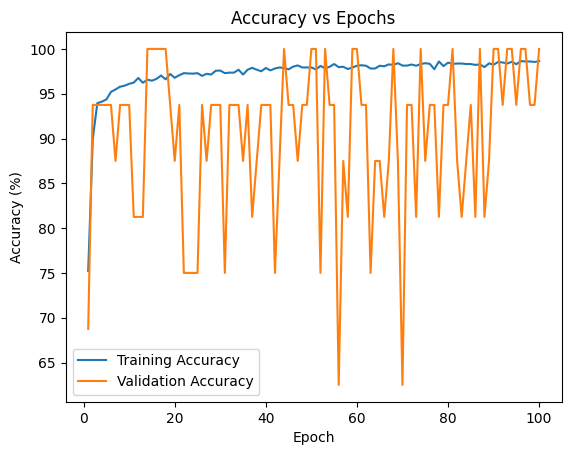

In [ ]:
model = models.vgg16(pretrained=True)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 100  # Set the number of epochs
train_accuracies = []  # Initialize list to store training accuracies
valid_accuracies = []  # Initialize list to store validation accuracies
batch_size = 64

train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Evaluation on validation set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    valid_accuracy = 100 * correct / total
    valid_accuracies.append(valid_accuracy)

    print('Epoch: %d/%d, Loss: %.4f, Train Accuracy: %.2f%%, Validation Accuracy: %.2f%%' % (
        epoch + 1, num_epochs, running_loss / len(train_loader), train_accuracy, valid_accuracy))

# Plot accuracy versus epoch
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

## Testing VGG with epoch 100

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize variables for calculating accuracy
correct = 0
total = 0

# Iterate through the test dataset
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)  # Move data to GPU
        # Forward pass
        outputs = model(data)
        # Get predicted labels
        _, predicted = torch.max(outputs.data, 1)
        # Update total number of samples
        total += target.size(0)
        # Update number of correctly classified samples
        correct += (predicted == target).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print('Accuracy on test set: {:.2f}%'.format(accuracy))

Accuracy on test set: 87.18%
